## Notebook 1: Regression of energy consumption in building design

**1. Prepare Problem**

In [1]:
# a) Load libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import matplotlib.pyplot as plt

import xgboost as xgb
from tensorflow import keras
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from keras.layers import Reshape, Conv2D, BatchNormalization, Dropout, Dense, Flatten 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

from pickle import dump

import warnings
warnings.filterwarnings("ignore", message="pandas.Int64Index is deprecated")

D:\Software\Anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# b) Load dataset
# Load and view each file in the dataset
data = pd.read_csv('EPB_data.csv', header=0)
print(data.shape)
print(data.head(10))
print(data.dtypes)

(768, 10)
   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   
5                  0.90         563.5      318.5     122.50             7.0   
6                  0.90         563.5      318.5     122.50             7.0   
7                  0.90         563.5      318.5     122.50             7.0   
8                  0.86         588.0      294.0     147.00             7.0   
9                  0.86         588.0      294.0     147.00             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  Heating Load  \
0            2           0.0                   

One of the approach in optimizing building energy efficiency is to minimize total energy consumption, which is the sum of heating and cooling.

In [3]:
# Calculate total energy consumption by summing up heating and cooling loads
data['Energy Consumption'] = data[['Heating Load', 'Cooling Load']].sum(axis=1)
print(data.shape)

# Define features and label
X = data.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
y = data['Energy Consumption']

(768, 11)


**2. Dataset summary**

In [4]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

       Relative Compactness  Surface Area  Wall Area  Roof Area  \
count               768.000       768.000    768.000    768.000   
mean                  0.764       671.708    318.500    176.604   
std                   0.106        88.086     43.626     45.166   
min                   0.620       514.500    245.000    110.250   
25%                   0.682       606.375    294.000    140.875   
50%                   0.750       673.750    318.500    183.750   
75%                   0.830       741.125    343.000    220.500   
max                   0.980       808.500    416.500    220.500   

       Overall Height  Orientation  Glazing Area  Glazing Area Distribution  \
count         768.000      768.000       768.000                    768.000   
mean            5.250        3.500         0.234                      2.812   
std             1.751        1.119         0.133                      1.551   
min             3.500        2.000         0.000                      0.000   
2

In [5]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index([], dtype='object')

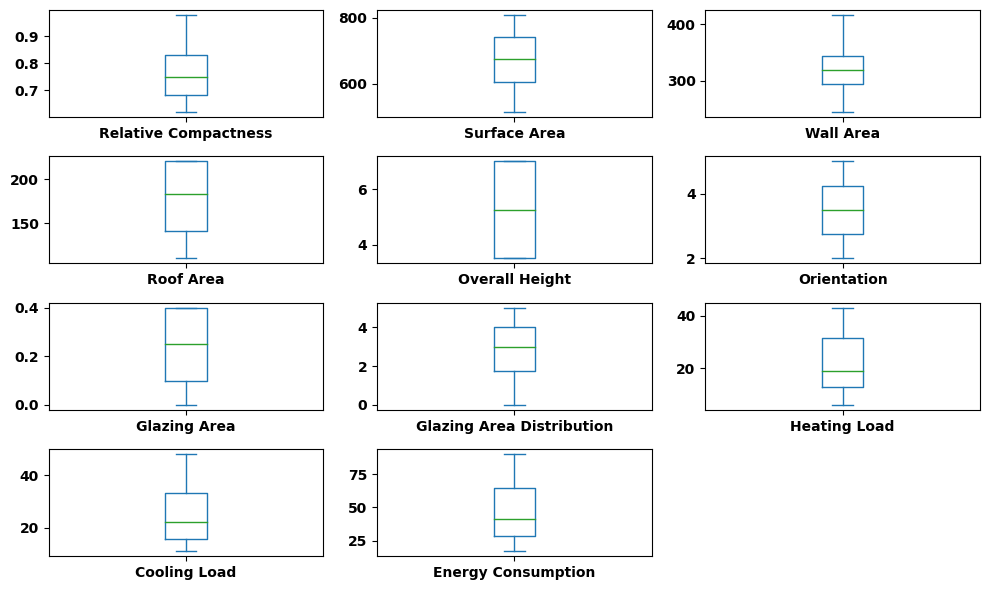

In [6]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.show()

We can see the data skewed to high values in relative compactness, roof area, glazing area, and cooling load.

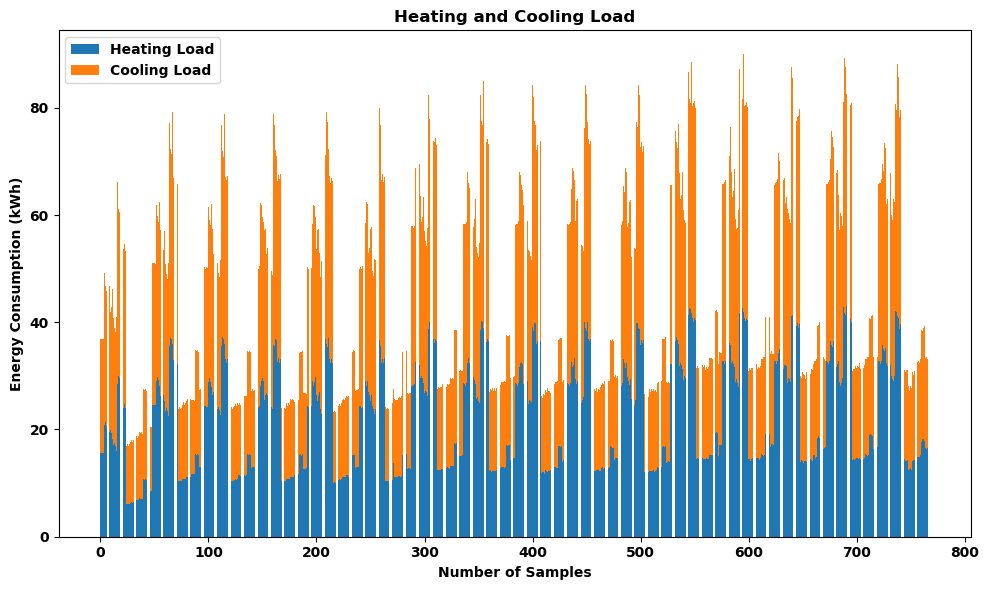

In [7]:
# create the stack bar chart of Heating and Cooling Load
fig, ax = plt.subplots()
ax.bar(np.arange(len(data['Heating Load'])), data['Heating Load'], label='Heating Load')
ax.bar(np.arange(len(data['Cooling Load'])), data['Cooling Load'], bottom=data['Heating Load'], label='Cooling Load')

# add labels, title and legend
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Heating and Cooling Load')
ax.legend()

# show the plot
plt.show()

The data displays a cyclical pattern that may have resulted from the measurements taken on weekdays (with longer hours) and weekends.

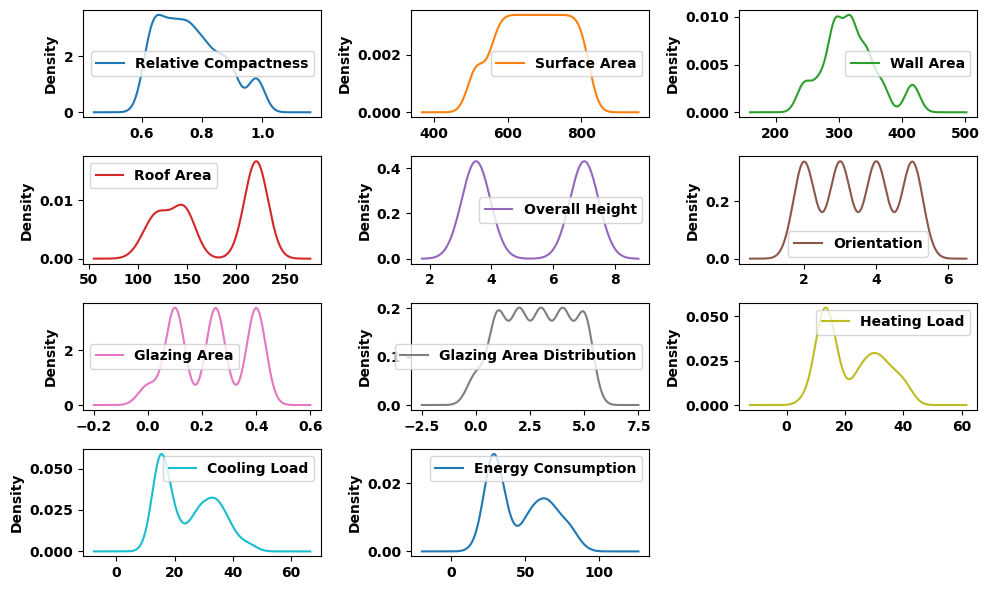

In [8]:
# Create density plots to check the Gaussian distribution of features
raw_plot.plot(kind='density', subplots=True, layout=(4,3), sharex=False)
plt.show()

The dataset seems to be complex as most of features exhibit non-Gaussian distributions, except for the Surface Area. There are several factors that could cause non-Gaussian distributions, including outliers, measurement errors, or the inherent characteristics of the building designs.

                           Relative Compactness  Surface Area  Wall Area  \
Relative Compactness                  1.000e+00    -9.919e-01 -2.038e-01   
Surface Area                         -9.919e-01     1.000e+00  1.955e-01   
Wall Area                            -2.038e-01     1.955e-01  1.000e+00   
Roof Area                            -8.688e-01     8.807e-01 -2.923e-01   
Overall Height                        8.277e-01    -8.581e-01  2.810e-01   
Orientation                           4.679e-17    -3.459e-17 -2.429e-17   
Glazing Area                         -2.961e-15     3.637e-15 -8.567e-17   
Glazing Area Distribution            -7.107e-16     2.438e-15  2.067e-16   
Heating Load                          6.223e-01    -6.581e-01  4.557e-01   
Cooling Load                          6.343e-01    -6.730e-01  4.271e-01   
Energy Consumption                    6.319e-01    -6.694e-01  4.445e-01   

                           Roof Area  Overall Height  Orientation  \
Relative Compactne

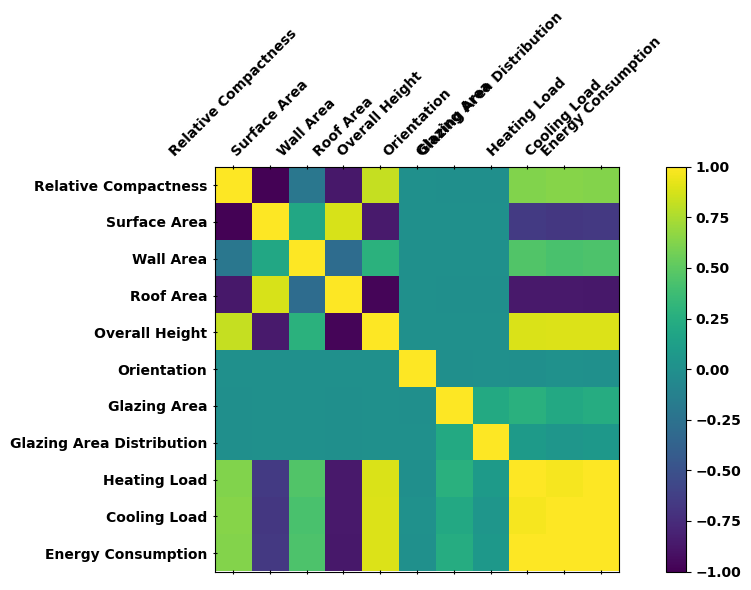

In [9]:
# correlation matrix between all pairs of attributes
print(data.corr(method='pearson'))
names = list(data)
fig = plt.figure()
sub_fig = fig.add_subplot(111)
cm = sub_fig.matshow(data.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cm)
sub_fig.tick_params(direction='inout')
sub_fig.set_xticks(np.arange(0,11))
sub_fig.set_yticks(np.arange(0,11))
sub_fig.set_xticklabels(names, rotation=45)
sub_fig.set_yticklabels(names)
plt.show()

According to the correlation matrix, the heating and cooling loads, as well as energy consumption, exhibit strong correlations with the overall height, orientation, and to some extent, the surface area. The orientation is considered to be an uncertain factor in building design due to limited choices compared to other variables and it plays a significant role in determining the energy efficiency of a building.

**3. Prepare Data**

In [10]:
# a) Data Cleaning
# summarize the number of unique values in each column
print(data.nunique())

Relative Compactness          12
Surface Area                  12
Wall Area                      7
Roof Area                      4
Overall Height                 2
Orientation                    4
Glazing Area                   4
Glazing Area Distribution      6
Heating Load                 586
Cooling Load                 636
Energy Consumption           700
dtype: int64


In [11]:
# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
Energy Consumption           0
dtype: int64


It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [12]:
# calculate the correlation between numerical columns and target variable
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Energy Consumption']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [13]:
# b) Split-out dataset into train, test, and validation sets

train = data[:int(len(data) * 0.75)]
validation = data[int(len(data) * 0.75):int(len(data) * 1)]
print(train.shape, validation.shape)

X_train = train.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
X_val = validation.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
y_train = train['Energy Consumption']
y_val = validation['Energy Consumption']

# For XGBoost model
X_train1 = train.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
y_train1 = train['Energy Consumption']

(576, 11) (192, 11)


In [14]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_val = DataFrame(X_val)

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(576, 8) (192, 8)
(576,) (192,)


**4. Evaluate Algorithms**

In [15]:
# a) Spot check algorithms using cross-validation technique
num_folds = 8
seed = 8

# Select 3 most popular algorithms for evaluation
models = []
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor()))

# Define the XGBoost model
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 10)
models.append(('XGB', model_xgb))

In [16]:
# Neural Network algorithms
# create keras Sequential model
def baseline_model():
    model = Sequential()
    model.add(Reshape((2, 4, 1), input_shape=(8,)))
    model.add(Conv2D(filters=32, kernel_size=(1, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(filters=64, kernel_size=(1, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer = 'adam',
                loss = 'mean_squared_error',
                metrics=['mse'])
    return model

# Build model
model_CNN = baseline_model()
models.append(('CNN', model_CNN))

In [17]:
# Define a callback for early stopping if the validation loss does not improve for 20 consecutive 
# epochs (patience=20).
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

In [18]:
results = []
alg_names = []

# Initialize the KerasRegressor estimator with early stopping
estimator = KerasRegressor(model=model_CNN, batch_size=128, verbose=1, callbacks=[early_stopping])

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    
    # modify loop for xgboost and CNN
    if name != ('XGB' and 'CNN'):
        cvs = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    else:    
        if name == 'CNN':
            validation_data = (X_val, y_val)
            cvs = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', fit_params={'validation_data': validation_data, 'epochs': 50})
        else:
            # create DMatrix from training data for XGBoost
            dtrain = xgb.DMatrix(X_train1, label=y_train1)
            cvs = cross_val_score(model_xgb, X_train1, y_train1, cv=kfold, scoring='neg_mean_squared_error')
    
    results.append(abs(cvs))
    alg_names.append(name)
    output = "%s: %f (%f)" % (name, abs(cvs).mean(), abs(cvs).std())
    print(output)

LR: 34.619996 (3.936559)
RF: 2.527043 (0.838472)
XGB: 2.861663 (0.710993)


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpqdj9hga4\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpqdj9hga4\assets


Epoch 1/50
4/4 [==============================] - 1s 83ms/step - loss: 2367.9065 - mse: 2367.9065 - val_loss: 3113.5872 - val_mse: 3113.5872
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 2248.3577 - mse: 2248.3577 - val_loss: 3103.2053 - val_mse: 3103.2053
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 2125.1238 - mse: 2125.1238 - val_loss: 3089.1599 - val_mse: 3089.1599
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 2006.6907 - mse: 2006.6907 - val_loss: 3070.5847 - val_mse: 3070.5847
Epoch 5/50
4/4 [==============================] - 0s 16ms/step - loss: 1844.8208 - mse: 1844.8208 - val_loss: 3046.2637 - val_mse: 3046.2637
Epoch 6/50
4/4 [==============================] - 0s 16ms/step - loss: 1668.5435 - mse: 1668.5435 - val_loss: 3014.7734 - val_mse: 3014.7734
Epoch 7/50
4/4 [==============================] - 0s 16ms/step - loss: 1491.4143 - mse: 1491.4143 - val_loss: 2975.4802 - val_mse: 2975.4802
Epoch 8/50
4/

INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmp257sy7cf\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmp257sy7cf\assets


Epoch 1/50
4/4 [==============================] - 1s 68ms/step - loss: 2291.8308 - mse: 2291.8308 - val_loss: 3113.4475 - val_mse: 3113.4475
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 2166.0291 - mse: 2166.0291 - val_loss: 3103.2275 - val_mse: 3103.2275
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 2053.1230 - mse: 2053.1230 - val_loss: 3089.4434 - val_mse: 3089.4434
Epoch 4/50
4/4 [==============================] - 0s 16ms/step - loss: 1919.9017 - mse: 1919.9017 - val_loss: 3071.5098 - val_mse: 3071.5098
Epoch 5/50
4/4 [==============================] - 0s 16ms/step - loss: 1770.7393 - mse: 1770.7393 - val_loss: 3047.6270 - val_mse: 3047.6270
Epoch 6/50
4/4 [==============================] - 0s 16ms/step - loss: 1613.5151 - mse: 1613.5151 - val_loss: 3016.5847 - val_mse: 3016.5847
Epoch 7/50
4/4 [==============================] - 0s 10ms/step - loss: 1471.4353 - mse: 1471.4353 - val_loss: 2977.6648 - val_mse: 2977.6648
Epoch 8/50
4/

INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpyv0hzku1\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpyv0hzku1\assets


Epoch 1/50
4/4 [==============================] - 1s 135ms/step - loss: 2321.4429 - mse: 2321.4429 - val_loss: 3113.3396 - val_mse: 3113.3396
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 2203.3762 - mse: 2203.3762 - val_loss: 3102.9834 - val_mse: 3102.9834
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 2089.6494 - mse: 2089.6494 - val_loss: 3089.0986 - val_mse: 3089.0986
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 1956.8634 - mse: 1956.8634 - val_loss: 3070.3870 - val_mse: 3070.3870
Epoch 5/50
4/4 [==============================] - 0s 16ms/step - loss: 1807.9651 - mse: 1807.9651 - val_loss: 3046.3259 - val_mse: 3046.3259
Epoch 6/50
4/4 [==============================] - 0s 16ms/step - loss: 1645.8639 - mse: 1645.8639 - val_loss: 3015.3425 - val_mse: 3015.3425
Epoch 7/50
4/4 [==============================] - 0s 16ms/step - loss: 1467.4680 - mse: 1467.4680 - val_loss: 2975.2676 - val_mse: 2975.2676
Epoch 8/50
4

INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmptbbpvjrw\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmptbbpvjrw\assets


Epoch 1/50
4/4 [==============================] - 1s 68ms/step - loss: 2325.1033 - mse: 2325.1033 - val_loss: 3112.9192 - val_mse: 3112.9192
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 2199.1855 - mse: 2199.1855 - val_loss: 3102.6145 - val_mse: 3102.6145
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 2083.7141 - mse: 2083.7141 - val_loss: 3088.7715 - val_mse: 3088.7715
Epoch 4/50
4/4 [==============================] - 0s 16ms/step - loss: 1962.7256 - mse: 1962.7256 - val_loss: 3071.1667 - val_mse: 3071.1667
Epoch 5/50
4/4 [==============================] - 0s 16ms/step - loss: 1802.1260 - mse: 1802.1260 - val_loss: 3048.2810 - val_mse: 3048.2810
Epoch 6/50
4/4 [==============================] - 0s 16ms/step - loss: 1669.7781 - mse: 1669.7781 - val_loss: 3018.9226 - val_mse: 3018.9226
Epoch 7/50
4/4 [==============================] - 0s 10ms/step - loss: 1477.5801 - mse: 1477.5801 - val_loss: 2981.9023 - val_mse: 2981.9023
Epoch 8/50
4/

INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpn3c_k3gm\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpn3c_k3gm\assets


Epoch 1/50
4/4 [==============================] - 1s 68ms/step - loss: 2373.2986 - mse: 2373.2986 - val_loss: 3113.8567 - val_mse: 3113.8567
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 2254.9116 - mse: 2254.9116 - val_loss: 3103.2898 - val_mse: 3103.2898
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 2134.7622 - mse: 2134.7622 - val_loss: 3089.2559 - val_mse: 3089.2559
Epoch 4/50
4/4 [==============================] - 0s 16ms/step - loss: 1998.8524 - mse: 1998.8524 - val_loss: 3070.6707 - val_mse: 3070.6707
Epoch 5/50
4/4 [==============================] - 0s 16ms/step - loss: 1847.0389 - mse: 1847.0389 - val_loss: 3046.6135 - val_mse: 3046.6135
Epoch 6/50
4/4 [==============================] - 0s 10ms/step - loss: 1677.8668 - mse: 1677.8668 - val_loss: 3015.7131 - val_mse: 3015.7131
Epoch 7/50
4/4 [==============================] - 0s 16ms/step - loss: 1502.1663 - mse: 1502.1663 - val_loss: 2976.5012 - val_mse: 2976.5012
Epoch 8/50
4/

1/1 [==============================] - 0s 94ms/step


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmp0bgq7_fq\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmp0bgq7_fq\assets


Epoch 1/50
4/4 [==============================] - 1s 68ms/step - loss: 2322.0369 - mse: 2322.0369 - val_loss: 3113.8914 - val_mse: 3113.8914
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 2202.5605 - mse: 2202.5605 - val_loss: 3103.5691 - val_mse: 3103.5691
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 2078.8704 - mse: 2078.8704 - val_loss: 3089.6853 - val_mse: 3089.6853
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 1932.0627 - mse: 1932.0627 - val_loss: 3071.6055 - val_mse: 3071.6055
Epoch 5/50
4/4 [==============================] - 0s 10ms/step - loss: 1801.0127 - mse: 1801.0127 - val_loss: 3048.0168 - val_mse: 3048.0168
Epoch 6/50
4/4 [==============================] - 0s 16ms/step - loss: 1641.8140 - mse: 1641.8140 - val_loss: 3017.3711 - val_mse: 3017.3711
Epoch 7/50
4/4 [==============================] - 0s 16ms/step - loss: 1464.5353 - mse: 1464.5353 - val_loss: 2979.1250 - val_mse: 2979.1250
Epoch 8/50
4/

1/1 [==============================] - 0s 114ms/step


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpjn8bojo9\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpjn8bojo9\assets


Epoch 1/50
4/4 [==============================] - 1s 94ms/step - loss: 2374.3210 - mse: 2374.3210 - val_loss: 3113.3096 - val_mse: 3113.3096
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 2254.1084 - mse: 2254.1084 - val_loss: 3102.2605 - val_mse: 3102.2605
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 2132.5100 - mse: 2132.5100 - val_loss: 3087.8213 - val_mse: 3087.8213
Epoch 4/50
4/4 [==============================] - 0s 16ms/step - loss: 1989.2264 - mse: 1989.2264 - val_loss: 3068.9343 - val_mse: 3068.9343
Epoch 5/50
4/4 [==============================] - 0s 16ms/step - loss: 1853.5599 - mse: 1853.5599 - val_loss: 3044.5925 - val_mse: 3044.5925
Epoch 6/50
4/4 [==============================] - 0s 10ms/step - loss: 1667.4232 - mse: 1667.4232 - val_loss: 3013.2295 - val_mse: 3013.2295
Epoch 7/50
4/4 [==============================] - 0s 16ms/step - loss: 1499.2332 - mse: 1499.2332 - val_loss: 2973.9968 - val_mse: 2973.9968
Epoch 8/50
4/

INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpbxd2ipc8\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpbxd2ipc8\assets


Epoch 1/50
4/4 [==============================] - 1s 68ms/step - loss: 2325.3376 - mse: 2325.3376 - val_loss: 3113.0188 - val_mse: 3113.0188
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 2214.6548 - mse: 2214.6548 - val_loss: 3102.7097 - val_mse: 3102.7097
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 2095.0518 - mse: 2095.0518 - val_loss: 3088.5735 - val_mse: 3088.5735
Epoch 4/50
4/4 [==============================] - 0s 16ms/step - loss: 1957.3940 - mse: 1957.3940 - val_loss: 3070.2239 - val_mse: 3070.2239
Epoch 5/50
4/4 [==============================] - 0s 16ms/step - loss: 1825.1240 - mse: 1825.1240 - val_loss: 3046.3193 - val_mse: 3046.3193
Epoch 6/50
4/4 [==============================] - 0s 16ms/step - loss: 1650.9073 - mse: 1650.9073 - val_loss: 3015.8145 - val_mse: 3015.8145
Epoch 7/50
4/4 [==============================] - 0s 16ms/step - loss: 1480.5881 - mse: 1480.5881 - val_loss: 2977.2463 - val_mse: 2977.2463
Epoch 8/50
4/

Epoch 1/500
5/5 [==============================] - 1s 51ms/step - loss: 2331.2883 - mse: 2331.2883 - val_loss: 3111.5291 - val_mse: 3111.5291
Epoch 2/500
5/5 [==============================] - 0s 12ms/step - loss: 2185.4233 - mse: 2185.4233 - val_loss: 3097.2285 - val_mse: 3097.2285
Epoch 3/500
5/5 [==============================] - 0s 12ms/step - loss: 2024.7760 - mse: 2024.7760 - val_loss: 3077.0193 - val_mse: 3077.0193
Epoch 4/500
5/5 [==============================] - 0s 12ms/step - loss: 1855.4015 - mse: 1855.4015 - val_loss: 3049.4656 - val_mse: 3049.4656
Epoch 5/500
5/5 [==============================] - 0s 12ms/step - loss: 1666.0695 - mse: 1666.0695 - val_loss: 3012.4150 - val_mse: 3012.4150
Epoch 6/500
5/5 [==============================] - 0s 16ms/step - loss: 1438.5223 - mse: 1438.5223 - val_loss: 2962.8652 - val_mse: 2962.8652
Epoch 7/500
5/5 [==============================] - 0s 12ms/step - loss: 1204.9565 - mse: 1204.9565 - val_loss: 2898.3977 - val_mse: 2898.3977
Epoch 

5/5 [==============================] - 0s 12ms/step - loss: 43.9505 - mse: 43.9505 - val_loss: 362.5042 - val_mse: 362.5042
Epoch 61/500
5/5 [==============================] - 0s 12ms/step - loss: 46.9641 - mse: 46.9641 - val_loss: 356.1033 - val_mse: 356.1033
Epoch 62/500
5/5 [==============================] - 0s 8ms/step - loss: 41.3576 - mse: 41.3576 - val_loss: 341.8352 - val_mse: 341.8352
Epoch 63/500
5/5 [==============================] - 0s 12ms/step - loss: 44.6928 - mse: 44.6928 - val_loss: 323.4867 - val_mse: 323.4867
Epoch 64/500
5/5 [==============================] - 0s 12ms/step - loss: 46.4160 - mse: 46.4160 - val_loss: 313.4140 - val_mse: 313.4140
Epoch 65/500
5/5 [==============================] - 0s 12ms/step - loss: 44.2809 - mse: 44.2809 - val_loss: 305.1078 - val_mse: 305.1078
Epoch 66/500
5/5 [==============================] - 0s 12ms/step - loss: 41.6910 - mse: 41.6910 - val_loss: 292.7184 - val_mse: 292.7184
Epoch 67/500
5/5 [==============================] - 0s 

Epoch 120/500
5/5 [==============================] - 0s 12ms/step - loss: 35.5921 - mse: 35.5921 - val_loss: 151.8163 - val_mse: 151.8163
Epoch 121/500
5/5 [==============================] - 0s 12ms/step - loss: 31.6577 - mse: 31.6577 - val_loss: 156.0915 - val_mse: 156.0915
Epoch 122/500
5/5 [==============================] - 0s 8ms/step - loss: 33.5455 - mse: 33.5455 - val_loss: 164.2531 - val_mse: 164.2531
Epoch 123/500
5/5 [==============================] - 0s 12ms/step - loss: 34.7550 - mse: 34.7550 - val_loss: 165.7846 - val_mse: 165.7846
Epoch 124/500
5/5 [==============================] - 0s 12ms/step - loss: 37.5138 - mse: 37.5138 - val_loss: 165.4369 - val_mse: 165.4369
Epoch 125/500
5/5 [==============================] - 0s 8ms/step - loss: 33.0374 - mse: 33.0374 - val_loss: 167.9653 - val_mse: 167.9653
Epoch 126/500
5/5 [==============================] - 0s 12ms/step - loss: 33.5333 - mse: 33.5333 - val_loss: 173.2405 - val_mse: 173.2405
Epoch 127/500
5/5 [=================

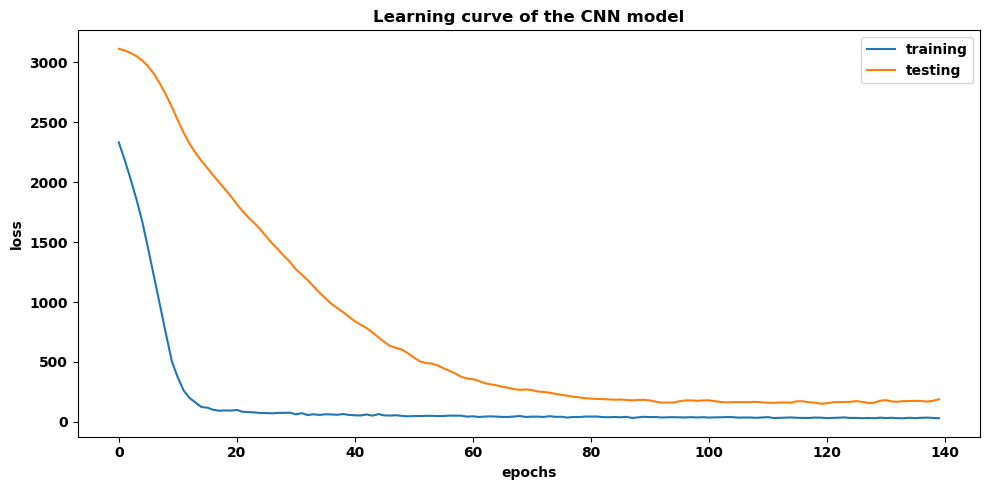

In [19]:
# Plot learning curve of CNN model
history = model_CNN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=128, callbacks=[early_stopping])

plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'testing')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Learning curve of the CNN model')
plt.legend()

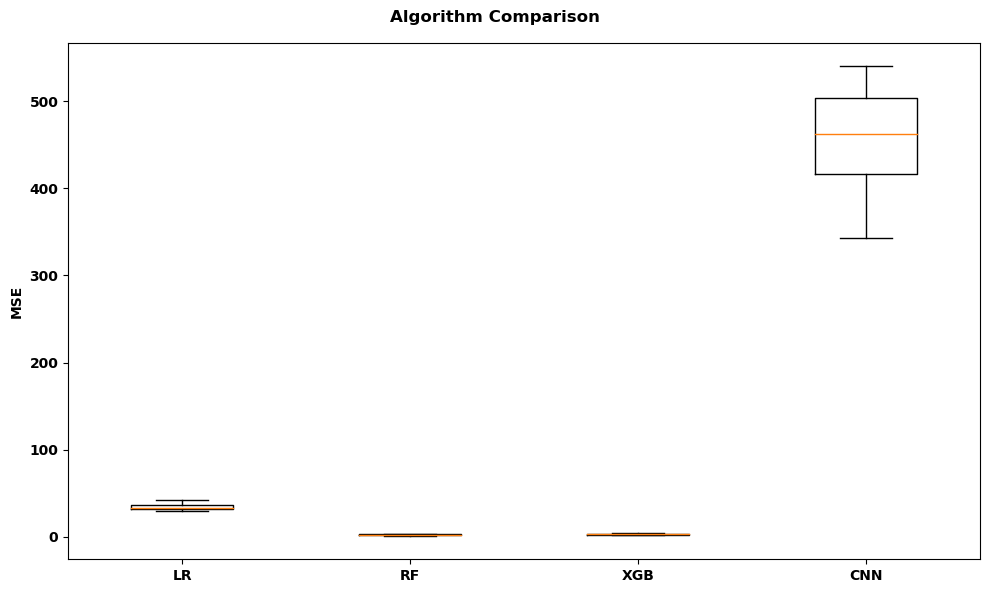

In [20]:
# b) Compare algorithms and the CNN model
# Distribution of accuracy values calculated across 8 cross-validation folds.
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(alg_names)
plt.ylabel("MSE")
plt.show()

Of the three algorithms and CNN model, the ensemble models outperformed Linear Regression and CNN model, and for the sake of simplicity, I selected Random Forest as the surrogate model for the optimization process in the 2nd Notebook.

In a regression problem, it is common to use the mean error as a measure of validation. This is done by first calculating the mean absolute error (MAE) of the test data with the mean of dataset, and then calculating the MAE of the test data with the predicted data. 

In [21]:
# Define baseline mean_absolute_error of y_val in the data set
y_mean = np.mean(y)
y_mean = np.array([y_mean]*len(y_val))
mae_ori = mean_absolute_error(y_val, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

Mean Absolute Error of original data:  18.969166666666666


In [22]:
# Calculate mean_absolute_error of the prediction
model_RF = RandomForestRegressor(n_estimators=10)
model_RF.fit(X_val, y_val)
y_pred_RF = model_RF.predict(X_val)

mae_pred_RF = mean_absolute_error(y_val, y_pred_RF)
print("Mean Absolute Error of predicted data: ", mae_pred_RF)

Mean Absolute Error of predicted data:  0.47351562500000016


The training and validation loss values suggest that the accuracy of the ML algorithms in predicting the actual values is relatively low.

**5. Finalize Model**

In [23]:
# a) Get best model parameters
model_params = model_RF.get_params()

# Print the model's parameters
print(model_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


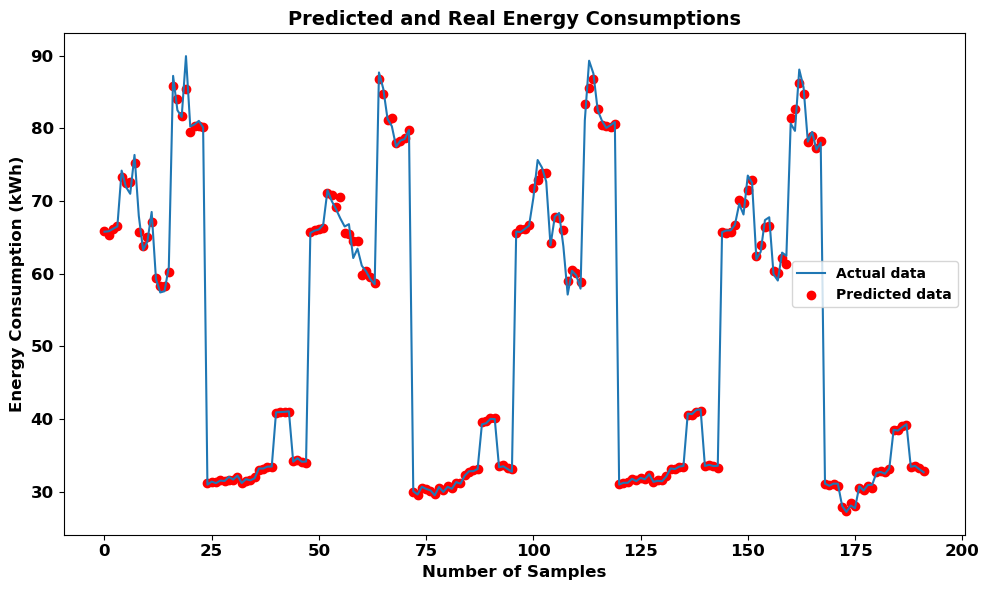

In [24]:
fig, ax = plt.subplots()

# Plot the actual data as a line chart
ax.plot(range(len(y_val)), y_val, label='Actual data')

# Overlay the predicted data as a scatter plot
ax.scatter(range(len(y_pred_RF)), y_pred_RF, label='Predicted data', color='red')

# Add labels, title, and legend
ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_ylabel('Energy Consumption (kWh)', fontsize=12)
ax.set_title('Predicted and Real Energy Consumptions', fontsize=14)
ax.legend()

# set tick font size for both axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

In [25]:
# b) Save model for later use
# save the model to disk
filename = 'finalized_model.sav'
dump(model_RF, open(filename, 'wb'))

**6. Conclusions**

- Exploratory data analysis shows that the input variables are almost non-Gaussian distribution.

- Among the three machine learning algorithms and convolutional neural network (CNN) model, Random Forest and XGBoost attained lowest Mean Squared Error values.

- The Mean Absolute Error values indicate that the prediction accuracy for the ensemble algorithms is excellent, whereas it was unexpectedly low for the CNN model.

- The performance of the CNN model (Keras Sequential) is worst than all ML algorithms. Further tunning of the hyperparameter may yield a better prediction score.